In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from MITgcmutils import mds
from jmd95 import eos
from pygamman import gamman
import os

%matplotlib inline


In [73]:
# make a T/S diagram of gamma_n and sigma 0

n = 200
T = np.linspace(-2.6,12,n)
S = np.linspace(35, 33.5, n)
SS, TT = np.meshgrid(S,T)

lon = 0.
lat = -60.
PP = np.zeros_like(SS)
PP2 = 2000*np.ones_like(SS)

N = len(T)*len(S)

# surface sigma0
gn, dg_lo, dg_hi = gamman.gamma_n(SS.ravel(), TT.ravel(), PP.ravel(), N, lon, lat )
gn.shape = SS.shape
gn = np.ma.masked_less(gn, 0.)

# interior sigma2
gn2, _, _ = gamman.gamma_n(SS.ravel(), TT.ravel(), PP2.ravel(), N, lon, -30 )
gn2.shape = SS.shape
gn2 = np.ma.masked_less(gn2, 0.)


sig02d, _, _ = eos.state_surface(TT, SS)
sig22d, _, _ = eos.state(2000, TT, SS)

In [3]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_matt'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


## data.diagnostics ##

    frequency(1) = 2629200.0,
    fields(1,1) = 'SIarea  ',
                 'SIheff  ',
                 'SIhsnow ',
                 'SItflux ',
                 'SIatmQnt',
                 'SIempmr ',
                 'SIatmFW ',
                 'SIuheff ',
                 'SIvheff ',
                 'TFLUX   ',
                 'SFLUX   ',
                 'THETA   ',
                 'SALT    ',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-monthly',




In [4]:
nrec = 0
new_ddir = '/data/scratch/rpa/SOSE/matt_iter100'


# 5 day output; want to sample different seasons
Nt = 438
# once every season for six years
recs = np.arange(0,Nt,18)

gamma = mds.rdmds(os.path.join(new_ddir, 'GAMMA.0000000100'), rec=recs, usememmap=True)
theta = mds.rdmds(os.path.join(new_ddir, 'THETA.0000000100'), rec=recs, usememmap=True)
salt = mds.rdmds(os.path.join(new_ddir, 'SALT.0000000100'), rec=recs, usememmap=True)

In [40]:
m.zc.shape

(42,)

In [43]:
import xray as xr
ds = xr.Dataset({'gamma': (('time', 'depth', 'lat', 'lon'), gamma),
                 'theta': (('time', 'depth', 'lat', 'lon'), theta),
                 'salt': (('time', 'depth', 'lat', 'lon'), salt),
                 'mask': (('depth', 'lat', 'lon'), m.mask)
                },
                {'depth': ('depth', m.zc), 'lat': ('lat', m.yc[0,:,0]), 'lon': ('lon', m.xc[0,0,:])})
ds

<xray.Dataset>
Dimensions:  (depth: 42, lat: 320, lon: 2160, time: 25)
Coordinates:
  * lat      (lat) float64 -77.87 -77.71 -77.54 -77.37 -77.21 -77.04 -76.87 ...
  * depth    (depth) float64 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 -104.0 ...
  * lon      (lon) float64 0.08333 0.25 0.4167 0.5833 0.75 0.9167 1.083 1.25 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    theta    (time, depth, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salt     (time, depth, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    mask     (depth, lat, lon) bool True True True True True True True True ...
    gamma    (time, depth, lat, lon) float64 -9.999e+03 -9.999e+03 ...

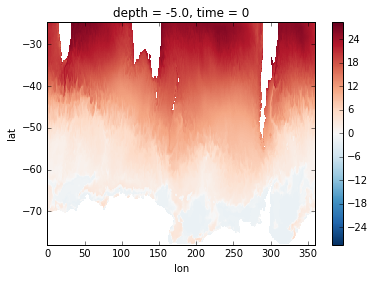

In [44]:
ds.theta.where(~ds.mask)[0,0].plot()

In [45]:
ds_wed = ds.where(~ds.mask).sel(lat=slice(-90,-70), lon=slice(290,360))
ds_wed

<xray.Dataset>
Dimensions:  (depth: 42, lat: 48, lon: 420, time: 25)
Coordinates:
  * lat      (lat) float64 -77.87 -77.71 -77.54 -77.37 -77.21 -77.04 -76.87 ...
  * depth    (depth) float64 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 -104.0 ...
  * lon      (lon) float64 290.1 290.2 290.4 290.6 290.8 290.9 291.1 291.2 ...
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    theta    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    salt     (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...
    mask     (depth, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    gamma    (time, depth, lat, lon) float64 nan nan nan nan nan nan nan nan ...

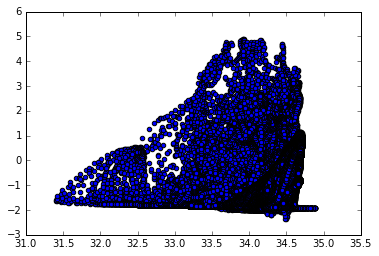

In [49]:
plt.scatter(ds_wed.salt, ds_wed.theta)


<a list of 9 text.Text objects>

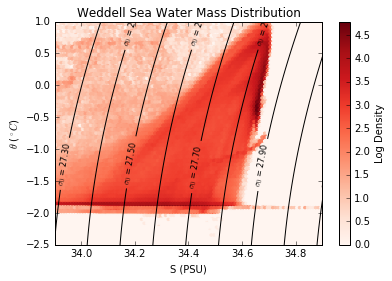

In [89]:
plt.hexbin(ds_wed.salt.to_masked_array().compressed(),
           ds_wed.theta.to_masked_array().compressed(),
           extent=(33.9,34.9,-2.5,1.0), bins='log', cmap='Reds')
cb = plt.colorbar()
plt.title('Weddell Sea Water Mass Distribution')
plt.xlabel('S (PSU)')
plt.ylabel(r'$\theta$ ($^\circ C$)')
cb.set_label('Log Density')

csg = plt.contour(SS[:50], TT[:50], sig02d[:50]-1000,
                  np.arange(27.3,28.2,0.1), colors='k', label=r'$\sigma_0$')
plt.ylim([-2.5,1.0])
plt.xlim([33.9,34.9])

plt.clabel(csg, fmt=r'$\sigma_0$ = %3.2f', fontsize=8)


In [88]:
T[50]

1.0683417085427132

In [ ]:
sig0, _, _ = eos.state_surface(theta.ravel(), salt.ravel())
sig0.shape = theta.shape
sigma0 = np.ma.masked_array(sig0-1000, gmask)

In [6]:
sig2, _, _ = eos.state(2000, theta.ravel(), salt.ravel())
sig2.shape = theta.shape

In [8]:
sigma2 = np.ma.masked_array(sig2-1000, gmask)
del sig2